In [8]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
from typing import Union

In [36]:
# Model / data parameters
num_classes = 10

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range for dense model
x_train_dense = x_train.reshape((x_train.shape[0], x_train.shape[1]*x_train.shape[2])).astype("float32") / 255
x_test_dense =  x_test.reshape((x_test.shape[0], x_test.shape[1]*x_test.shape[2])).astype("float32") / 255


In [37]:

model = keras.models.load_model("h5/mnist_high_complexity_float32_tanh.h5")



7


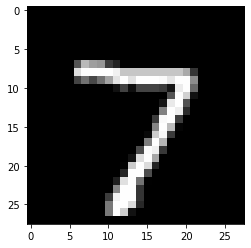

In [38]:
x, y = x_test_dense[0], y_test[0]
x_plot = np.reshape(x, (28,28))
plt.imshow(x_plot, cmap="gray")
res =model.predict(np.array([x]))
print(np.argmax(res))

In [39]:
def representative_data_gen():

  for input_value in np.array(x_train_dense):
    # Model has only one input so each data point has one element.
    yield [input_value]

In [41]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to int8 (APIs added in r2.3)
#converter.inference_input_type =  tf.int8
#converter.inference_output_type = tf.int8

tflite_model_quant = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\JORGE~1.RUI\AppData\Local\Temp\tmpq33up0vv\assets


INFO:tensorflow:Assets written to: C:\Users\JORGE~1.RUI\AppData\Local\Temp\tmpq33up0vv\assets


In [42]:
import pathlib

tflite_models_dir = pathlib.Path("./tflite")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

# Save the quantized model:
tflite_model_quant_file = tflite_models_dir/f"quantized_model.tflite"
tflite_model_quant_file.write_bytes(tflite_model_quant)

13056

In [21]:
def to_int8(real_value: np.ndarray , input_zero_point: int, input_scale: float):
    return (real_value / input_scale - input_zero_point).astype(np.int8)

def from_int8(int8_val: np.ndarray, output_zero_point: int, output_scale: float):
    return (int8_val.astype(np.float32) - output_zero_point) * output_scale

In [25]:
interpreter = tf.lite.Interpreter(model_path=str(tflite_model_quant_file), experimental_preserve_all_tensors=True)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()[0]
output_details = interpreter.get_output_details()[0]
input_scale, input_zero_point = input_details["quantization"]
output_scale, output_zero_point = output_details["quantization"]
print(f"input_scale: {input_scale} zero_point: {input_zero_point}")

hit = 0
for x,y  in zip(x_test_dense, y_test):
    x = np.array(x)
    x = to_int8(np.array(x), input_zero_point, input_scale) 
    
    interpreter.set_tensor(input_details["index"], np.expand_dims(np.array(x).astype(np.int8), axis=0))
    interpreter.invoke()
    res_int8 = interpreter.get_tensor(output_details["index"])[0]
    
    if np.argmax(res_int8) == y:
        hit += 1

print(hit / len(y_test))


hit = 0

res = model.predict(np.array(x_test_dense))
    
for softmax, y in zip(res, y_test):
    predicted = np.argmax(softmax)
    if (predicted == y):
        hit += 1
print(hit / len(y_test))

input_scale: 0.0 zero_point: 0


c:\Users\jorge.ruiz\Documents\venvs\movenet\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
c:\Users\jorge.ruiz\Documents\venvs\movenet\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


ValueError: Cannot set tensor: Got value of type INT8 but expected type FLOAT32 for input 0, name: dense_input 